Introducción

A través de este notebook podemos conocer todos los módulos del paquete. 
Toda la configuración está almacenada en config/parameters, siendo este módulo un ejecutable, preparado para limpiar y conocer la información de las fuentes de datos que se trabajan.
Se va a trabajar con dos csv: costes y fabricaciones. El objetivo es limpiar, transformar y hacer manejables las dos fuentes, y combinarlas para poder extraer los costes de fabricación para cada artículo. 

In [1]:
import sys
import os
import pandas as pd
from pathlib import Path

In [2]:
# Add the src directory to the Python path
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

In [3]:
from calculadora_costes.cleaning.cleaner_df import DataFrameCleaner
from calculadora_costes.config.parameters import Parameters
from calculadora_costes.services.validator import Validator
from calculadora_costes.services.outliers_manager import OutliersManager
from calculadora_costes.services.cost_calculator import CostCalculator
from calculadora_costes.services.encoder import Encoder
from calculadora_costes.services import VisualizationManager
from calculadora_costes.services.visualizations_manager import VisualizationError

In [4]:
project_root_path = Path(src_path).parent
data_path = project_root_path / 'data'
raw_path = data_path / 'raw'
clean_path = data_path / 'clean'

ETL master_lotes

costes.csv se exporta directamente del ERP y contiene información de todas las compras que se han hecho en la empresa. Por lo tanto, hay registros de todos los precios de compra, asociados a un articulo/ componente y un lote. 

Principalmente el uso de este DataFrame - master_lotes - es poder identificar los registros de los componentes y crear claves únicas con la que poder unir varios Dataframes.

master_lotes tiene por finalidad ser un listado ordenado y limpio con iformación de todos los lotes que existen dentro de la empresa (de artículos de compra, de venta, auxiliares, etc). Cada lote_interno va a asociado a su articulo y a su lote_proveedor. 

Esto es porque aunque la empresa trabaja siempre con lote_interno, hay algunos listados que el ERP solo es capaz de extraer con lote_proveedor.  

In [5]:
# Data extraction using the project root path
master_lotes = pd.read_csv(raw_path / 'costes.csv',  encoding='UTF-8', sep=';', dtype=str)

In [6]:
# Data visualization
master_lotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19326 entries, 0 to 19325
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Cód. almacén estructura  8047 non-null   object
 1   DESCALM                  8047 non-null   object
 2   Cód. artículo            19326 non-null  object
 3   Artículo                 0 non-null      object
 4   FECDOC                   8047 non-null   object
 5   LOTE                     19326 non-null  object
 6   FECCADUC                 8047 non-null   object
 7   LOTEINTERNO              19322 non-null  object
 8   UNIDADES                 8047 non-null   object
 9   PRCMONEDA                8047 non-null   object
 10  % descuento 1            8047 non-null   object
 11  TIPDOC                   8047 non-null   object
 12  NUMDOC                   8047 non-null   object
 13  REFERENCIA               8043 non-null   object
 14  Cód. proveedor           8047 non-null

DataFrameCleaner es el primer módulo del paquete. Su objetivo es limpiar los datos: elimminar columnas, renombrar, eliminar nulos, duplicados, y devolver de nuevo el DataFrame master_lotes

Los parámetros de las funciones están definidos en config/parameter

In [7]:
cleaner = DataFrameCleaner(master_lotes)
params = Parameters.master_lotes

master_lotes = (cleaner
    .columns_cleaner.keep_and_rename(params.cols_to_keep, params.rename_map)
    .rows_cleaner.drop_duplicates()
    .rows_cleaner.drop_na(params.drop_na_subset)
    .data_cleaner.to_upper()
    .get_df()
)

Tras ejecutar la función cleaner, nos queda el siguiente DataFrame, con 3 columnas y ningún nulo:

In [8]:
master_lotes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19252 entries, 4 to 19325
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   articulo         19252 non-null  object
 1   lote_proveedor   19252 non-null  object
 2   lote_componente  19252 non-null  object
dtypes: object(3)
memory usage: 601.6+ KB


Para continuar con la limpieza, debemos asegurarnos que tanto los códigos de artículo como los lotes internos están correctamente definidos.
Para ellos usamos la función validate_with_map() que trabaja con regex para comprobar que los patrones son correctos.

Los parámetros también están definidos en config/params.

La clase Validator contiene una función privada que devuelve información de las filas eliminadas en caso de que existan. 
También contiene una función get_invalid() para poder explorar qué filas está reconociendo como inválidas-

In [9]:
validator = Validator(master_lotes)
master_lotes = (validator
    .validate_with_map(params.validation_map)
    .get_df()
)

Usamos otro módulo de services, en esta caso una pequeña utilidad para crear códigos únicos concatenando dos columnas del df.
En este caso usamos 'articulo' y 'lote_proveedor' y lo llamamos clave_merge, porque esta será su utilidad.

In [10]:
encoder = Encoder(master_lotes)
master_lotes = encoder.create_key(col1='articulo', col2='lote_proveedor', new_col_name='clave_merge')

In [11]:
# Check that there are no duplicates
duplicados = master_lotes['clave_merge'].duplicated().sum()
duplicados

np.int64(0)

Esta la forma final del DataFrame master_lotes, ya podemos exportar como master_lotes_clean.csv

In [12]:
master_lotes.sample(2)

,articulo,lote_proveedor,lote_componente,clave_merge
13783,MAT269,1205227,2306-088,MAT269-1205227
5271,SEM005,141219,141219,SEM005-141219


In [13]:
master_lotes.to_csv(clean_path / 'master_lotes_clean.csv', index=False)

ETL costes

El segundo DataFrame que queremos obtener es costes. Costes debe contener información de todas las compras de componentes que se han realizado, con información del componente, el lote asociado a dicho componente y su precio de compra. 

In [14]:
costes = pd.read_csv(raw_path / 'costes.csv',  encoding='UTF-8', sep=';', dtype=str)

In [15]:
costes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19326 entries, 0 to 19325
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Cód. almacén estructura  8047 non-null   object
 1   DESCALM                  8047 non-null   object
 2   Cód. artículo            19326 non-null  object
 3   Artículo                 0 non-null      object
 4   FECDOC                   8047 non-null   object
 5   LOTE                     19326 non-null  object
 6   FECCADUC                 8047 non-null   object
 7   LOTEINTERNO              19322 non-null  object
 8   UNIDADES                 8047 non-null   object
 9   PRCMONEDA                8047 non-null   object
 10  % descuento 1            8047 non-null   object
 11  TIPDOC                   8047 non-null   object
 12  NUMDOC                   8047 non-null   object
 13  REFERENCIA               8043 non-null   object
 14  Cód. proveedor           8047 non-null

Volvemos a ejecutar DataFrameCleaner de la misma forma que en el caso anterior. Como cada df tiene sus parámetros propios asociados, no hay que cambiar nada, solo volver a llamar la clase y a las funciones del cleaner que nos interesen.

In [16]:
cleaner = DataFrameCleaner(costes)
params = Parameters.costes

costes = (cleaner
    .rows_cleaner.drop_na(params.drop_na_subset)
    .rows_cleaner.drop_duplicates()
    .columns_cleaner.keep_and_rename(params.cols_to_keep, params.rename_map)
    .data_cleaner.fix_numeric_format(params.cols_to_float)
    .rows_cleaner.drop_duplicates_batch(params.drop_duplicates_subset)
    .data_cleaner.to_upper()
    .get_df()
)

Hacemos de nuevo uso del validador. En este caso sí que hay códigos de componentes y lotes mal definidos, por tanto nos devuelve un resumen de los cambios. En caso de que quisiéarmos conocer qué filas ha eliminado, podríamos ejecutar .get_invalid()

In [17]:
validator = Validator(costes)

costes = (validator
    .validate_with_map(params.validation_map)
    .get_df()
)


=== RESUMEN DE VALIDACIÓN ===
Tamaño inicial del DataFrame: 8000

Filas inválidas por columna:
  - componente: 1 filas
  - lote_componente: 21 filas

Tamaño final del DataFrame: 7978
Total filas eliminadas: 22


In [18]:
#invalid_rows = validator.get_invalid('lote_interno')
#print(invalid_rows.head(10))

También dentro de services tenemos la clase outliers_manager. Esta clase se encarga de buscar outliers en columnas numéricas (elegidas en Parameters) y sustituirlos por la media de su grupo. 

La forma de detectar outliers es asociar a cada un registro un 'z_score' basado en lo que cuántas desviaciones típicas se desvía el registro de la media del grupo. Los grupos son todas las compras de ese componente.

Tanto el nivel del z_score como las 'vueltas' que queremos que de la función para pulir los outliers está también definido en parameters.

En este caso también nos devuelve un resumen de los outliers encontrados y corregidos. Podríamos ampliar este informe usando .process_outliers(verbose = True) sin emabargo en este caso es suficiente con el resumen.

In [19]:
outliers_manager = OutliersManager(costes, Parameters.costes)
costes_procesados = (outliers_manager
    .process_outliers()
    .clean_columns()
    .get_df()
)


=== RESUMEN DE OUTLIERS ===
Outliers detectados inicialmente: 71
Outliers reemplazados por la media: 66
Outliers restantes: 5


Tras la limpieza, nos queda un df libre de outliers y de nulos. De esta forma nos aseguramos que todos los artículos tienen un lote_interno y un coste asociado.

Por lo tanto, podemos exportarlo para usar externamente y es seguro combinarlo con otros dataframes.

In [20]:
costes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7978 entries, 6788 to 17055
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   componente                 7978 non-null   object 
 1   coste_componente_unitario  7978 non-null   float64
 2   lote_componente            7978 non-null   object 
dtypes: float64(1), object(2)
memory usage: 249.3+ KB


In [21]:
costes.sample(2)

,componente,coste_componente_unitario,lote_componente
11295,MAT300,0.70,2202-147
16960,FCRO004,29.28,2503-141


In [22]:
costes.to_csv(clean_path / 'costes_clean.csv', index=False)

ETL fabricaciones

El csv de fabricaciones contiene información de todas las fabricaciones que se han realizado en 2024 y 2025 en la empresa. Cada fabricación tiene un número de orden, una fecha y todos los componentes que se han usado para fabricarlo. 

El objetivo de esta transformación es obtener un dataframe con el coste de todas las fabricaciones y a partir de él realizar análisis. 
Por ejemplo, la evolución de costes de determinados productos en el tiempo, comparación de precio por artículos, etc.

In [23]:
fabricaciones = pd.read_csv(raw_path / 'fabricaciones.csv',  encoding='UTF-8', sep=';', dtype=str)

In [24]:
fabricaciones.sample(2)

,Fecha Recepción,Nº Orden,Producto,Descripción Producto,Lote Producto,Unidades Fabricadas,Componente,Descripción Componente,Lote Componente,Línea,Familia,Consumo Teórico,Total Teórico,Consumo Unitario,Consumo Total,Coste Unitario,Coste Total
7549,18/06/2024,FV-9744,SEM102,NaN,170624,"150,00",MAT373,NaN,ALB-BOP2406AV0037,COMPONENTE,MATERIA PRIMA,"6,02","902,33","5,16","774,20","5,90","4.567,78"
5394,02/05/2024,FV-9451,SEM095,NaN,300424,"2.120,00",MAT339,NaN,130224/060324,COMPONENTE,MATERIA PRIMA,"0,03","70,30","0,03","69,09","2,11","145,56"


Con el siguiente bloque cocatenamos los dos DataFrames que ya teníamos limpios costes y master_lotes para usarlos junto a fabricaciones. 

In [25]:
# No queremos trabajar con lote_componente_proveedor, unimos a master_lotes para obtener lote_componente
fabricaciones = Encoder(fabricaciones).create_key(col1='Componente', col2='Lote Componente', new_col_name='clave_merge')
fabricaciones = fabricaciones.merge(master_lotes, on="clave_merge", how="left")

# Merge fabricaciones y costes
fabricaciones = Encoder(fabricaciones).create_key(col1='articulo', col2='lote_componente', new_col_name='clave_merge')
costes = Encoder(costes).create_key(col1='componente', col2='lote_componente', new_col_name='clave_merge')
fabricaciones = fabricaciones.merge(costes, on="clave_merge", how="left")

# Creamos clave única para usar la función recursiva de costes
fabricaciones = Encoder(fabricaciones).create_key(col1='Producto', col2='Lote Producto', new_col_name='clave_unica')

Pasamos el cleaner a fabricaciones para limpiarlo.

In [26]:
cleaner = DataFrameCleaner(fabricaciones)
params = Parameters.fabricaciones

fabricaciones = (cleaner
    .rows_cleaner.drop_duplicates()
    .columns_cleaner.keep_and_rename(params.cols_to_keep, params.rename_map)
    .data_cleaner.fix_numeric_format(params.cols_to_float)
    .data_cleaner.fix_date_format(params.cols_to_date)
    .rows_cleaner.drop_na(params.drop_na_subset)
    .data_cleaner.to_upper()
    .get_df()
)

In [27]:
fabricaciones.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19580 entries, 0 to 19658
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id_orden                   19580 non-null  object        
 1   fecha_fabricacion          19580 non-null  datetime64[ns]
 2   articulo                   19580 non-null  object        
 3   lote_articulo              19580 non-null  object        
 4   unidades_fabricadas        19580 non-null  float64       
 5   componente                 19580 non-null  object        
 6   lote_componente            19580 non-null  object        
 7   coste_componente_unitario  16619 non-null  float64       
 8   consumo_unitario           19580 non-null  float64       
 9   consumo_total              19580 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 1.6+ MB


Uno de los problemas que presenta fabricaciones y nos impide calcular los costes de forma directa es que algunos articulos fabricados son componentes de otros (a partir de ahora los llamaremos semielaborados). Por lo tanto, no aparecen en el dataframe de costes, ya que recordemos que este recogía solo las compras. 
Como vemos al ejecutar info(), la columna de coste_componente_unitario es la única con nulos.

Para solucionar este problema se ha creado la clase CostCalculator. Esta clase se encarga de ejecutar una función que calcula los costes de forma iterativa. Es decir, primero calcula el coste de las fabricaciones que no se componen de semielaborados (mediante groupby + sum). Una vez tiene este primer batch, rellena los costes de los semielaborados que ha logrado obtener la función. 
Esta operación se repite hasta que ya no se pueden calcular más costes.

La función devuelve información sobre las iteraciones y lo que se está consiguiendo. En este caso, de 2961 nulos conseguimos calcular todos menos 11.

In [28]:
# Create instance of CostCalculator
calculador = CostCalculator(fabricaciones)
fabricaciones = calculador.calculate_costs_recursively()

Estado inicial: 2961 registros pendientes de calcular coste

Resumen por estado de cálculo:
Artículos pendientes: 112
Artículos calculados: 37

1ª iteración:
Registros sin coste: 2961

2ª iteración:
Registros sin coste: 1635

3ª iteración:
Registros sin coste: 384

4ª iteración:
Registros sin coste: 11

5ª iteración:
Registros sin coste: 11
No se pueden calcular más costes.

Resumen final:
Total registros: 19580
Registros sin coste: 11
Registros con coste calculado: 19569


A partir de esta limpieza logramos obtener dos sets de datos intersantes. Por una parte, tenemos el dataset de fabricaciones, con todos los componentes asociados a una producción, de forma que se pueden explotar datos del tipo: fallos en recetas, incrementos del coste, control de mermas, control de stock.

Por lo tanto, guardamos los datos obtenidos tras la limpieza.

In [29]:
fabricaciones.to_csv(clean_path / 'fabricaciones_clean.csv', index=False)

Además, otro set de datos muy interesante es el de las fabricaciones agrupadas por articulo final, sumando el coste por componente. De esta forma, tenemos dataframe con todas las fabricaciones, el coste unitario pos fabricación y la cantidad fabricada. 
Este set de datos nos permite analizar datos relacionados con los márgenes que deja cada producto al comparalos con el precio de venta, las cantidades por fabricación, en qué productos existen economías de escala, etc.

Para extraer este dataframe, volvemos a llamar al CostCalculator porque incluye una función que hace examente eso: extraer costes de fabricación agrupando por fabricación. La función de nos advierte de que faltan costes por calcular (los 11 que habíamos visto antes), pero igualmente procesa los datos y de las má de 19K registros, obtiene 2633 fabricaciones que han tenido lugar entre enero de 2024 y marzo de 2025.

In [30]:
# Luego generar el resumen de costes de fabricación
costes_fabricacion = calculador.generate_manufacturing_costs()

ADVERTENCIA: Hay costes pendientes de calcular. Los resultados pueden ser incompletos.

Resumen de costes de fabricación:
Total órdenes procesadas: 2633
Rango de fechas: 2024-01-02 00:00:00 a 2025-03-28 00:00:00


Aprovechamos nuestra función para detectar outliers en las fabricaciones. Estos outliers se tratan en la mayoría de casos de fallos humanos, arreglados a posteriori de forma manual, por lo que es interesante limpiarlos igualmente para los análisis. Sin embargo, en este caso es más interesante obtener el informe completo, para saber qué fabricaciones se salen de la media, para investigar en planta que es lo que pasa.

In [31]:
outliers_manager = OutliersManager(costes_fabricacion, Parameters.costes_fabricacion)

costes_fabricacion = (outliers_manager
    .process_outliers(verbose=True)
    .clean_columns()
    .get_df()
)


Analizando outliers por grupo...
  - Grupo FCAR002: 1 outliers detectados
    Media: 32.71, Std: 8.14
    Valores outlier: [1.287639]
  - Grupo FCAR008: 1 outliers detectados
    Media: 19.57, Std: 1.39
    Valores outlier: [25.672071380000002]
  - Grupo FCAR011: 1 outliers detectados
    Media: 65.90, Std: 0.18
    Valores outlier: [66.58847438240001]
  - Grupo FCAR015: 1 outliers detectados
    Media: 77.05, Std: 0.19
    Valores outlier: [76.35320914]
  - Grupo FCAR019: 1 outliers detectados
    Media: 3.21, Std: 0.17
    Valores outlier: [2.2546940965999998]
  - Grupo FCAR024: 1 outliers detectados
    Media: 68.81, Std: 0.48
    Valores outlier: [70.996048112]
  - Grupo FCAR046: 1 outliers detectados
    Media: 18.22, Std: 0.16
    Valores outlier: [18.771051036536]
  - Grupo FCAR047: 1 outliers detectados
    Media: 19.01, Std: 0.13
    Valores outlier: [19.422329774810002]
  - Grupo FCAR048: 1 outliers detectados
    Media: 58.89, Std: 0.10
    Valores outlier: [58.565492150000

Último servicio del paquete (hasta este momento) que se encarga de montar gráficos usando matplotlib.

De momento está pensado para recrear dos gráficos, uno con un solo artículo, para poder observar la evolución de costes en el tiempo y otro para comparar varios artículos.

Los parámetros están definidos en parameters (eje X, eje Y, título)...

Pero la decisión de qué datos consultar es del usuario. Por eso en este caso se han incluido varios bloques try/ except con la Excepción personalizada VisualizationError para capturar errores si el usuario no introduce artículo, introduce uno que no esté en el dataframe o las fechas son incorrectas.


Estadísticas para SCRE036:
 • Media:       0.77
 • Desv. Est.:  0.01
 • Mínimo:      0.74
 • Máximo:      0.78


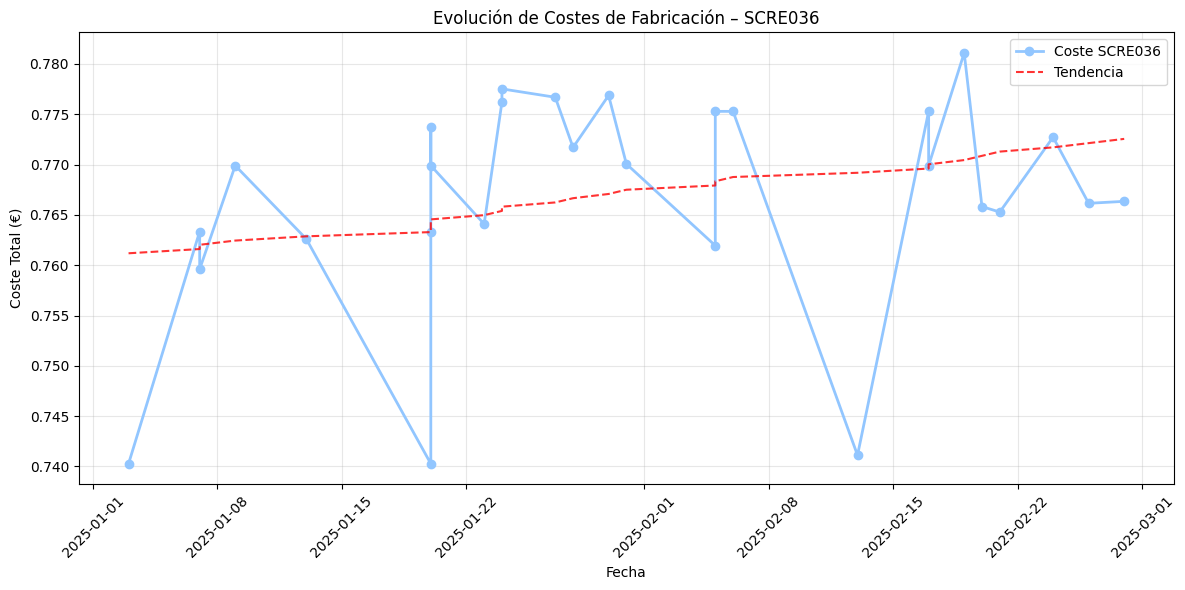

In [32]:
# Create the visualization manager
viz_manager = VisualizationManager(costes_fabricacion, Parameters.costes_fabricacion)

# Visualizate a single article over time
try:
    viz_manager.plot_time_series(
        articulo='SCRE036',
        start_date='2025-01-01',
        end_date='2025-02-28'
)
except VisualizationError as e:
    print("!", e)

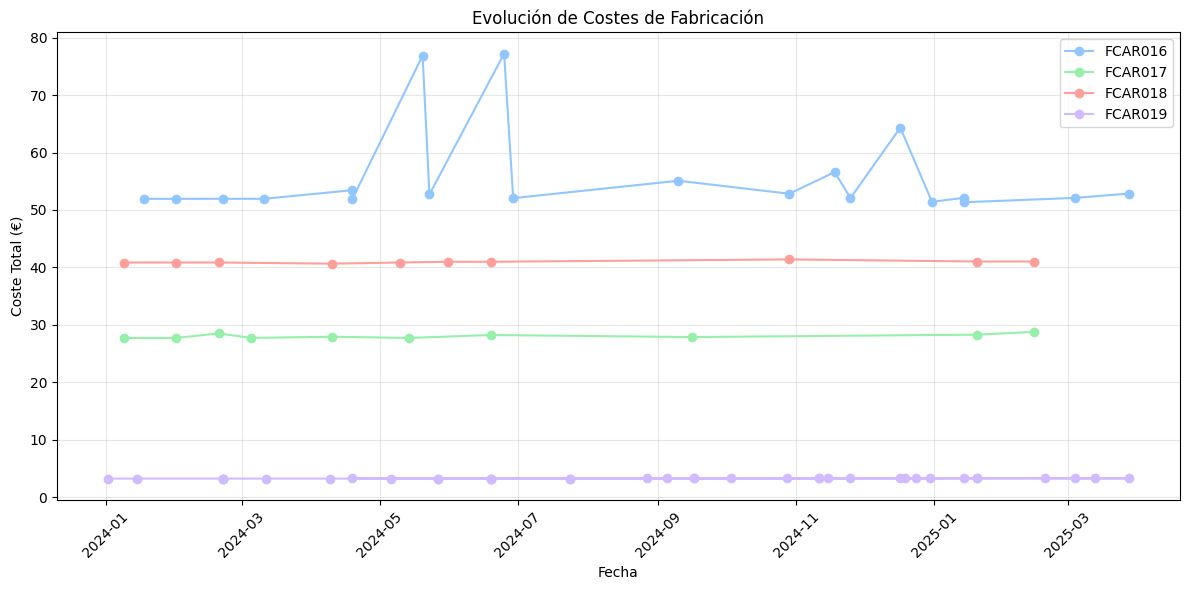

In [33]:
# Comparing multiple articles over time
try:
    viz_manager.plot_multiple_time_series(
        articulos=['FCAR016', 'FCAR017', 'FCAR018', 'FCAR019']
    )
except VisualizationError as e:
    print("!", e)

Aquí terminaría de momento el uso de este paquete. Sin embargo, esta hecho para que sea escalable tanto en nuevos dataframes como con nuevas funcionalidades.

Cada Clase trabaja por separado, por lo que solo tenemos que incluir dentro de services nuevas funciones. 

Por otra parte, si queremos trabajar con otro dataframe, lo único que hay que hacer es incluir sus particularidades en config/parameters y aplicar las funciones necesarias.